### Config The Platform, Crypto Algorithm and Oscope
In this step, we select the firmware that we need (TinyAES), the target board (CWLITEARM), and the ChipWhisperer scope.

In [19]:
import chipwhisperer as cw

PLATFORM = 'CW305_IBEX'

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()

try:
    print(SS_VER)
    if SS_VER == "SS_VER_2_1":
        target_type = cw.targets.SimpleSerial2
        print("INFO: Using SimpleSerial2")
    elif SS_VER == "SS_VER_2_0":
        raise OSError("SS_VER_2_0 is deprecated. Use SS_VER_2_1")
    else:
        target_type = cw.targets.SimpleSerial
        print("INFO: Using SimpleSerial")
except:
    SS_VER="SS_VER_1_1"
    target_type = cw.targets.SimpleSerial
    print("INFO: No SS_VER set, using SimpleSerial")

try:
    target = cw.target(scope, target_type)
except:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope, target_type)


print("INFO: Found ChipWhisperer😍")
scope.default_setup()
scope.gain.db = 20

# clocks:
print(scope.clock)
if PLATFORM == 'CW305_IBEX':
    print('Set the CW305 J16 switch to 1 so that Ibex is clocked from HS2. Note this is different from what most other CW305 notebooks require.')

scope.clock.clkgen_src = 'system'
if scope._is_husky:
    scope.clock.adc_mul = 1
else:
    scope.clock.adc_src = 'clkgen_x1'
scope.clock.clkgen_freq = 100e6

target.baud = 115200

# Ibex requires external JTAG programming
prog = None

# But let's program the FPGA bitfile:
if PLATFORM == 'CW305_IBEX':
    from chipwhisperer.hardware.firmware.cw305 import getsome
    bsdata = getsome(f"lowrisc_ibex_demo_system.bit")
    #cw305 = cw.target(None, cw.targets.CW305, bsfile="../../../../ibex/ibex-demo-system/build/lowrisc_ibex_demo_system_0/synth_cw305-vivado/lowrisc_ibex_demo_system_0.runs/impl_1/top_cw305.bit", force=False)
    cw305 = cw.target(None, cw.targets.CW305, bsfile="../ibex/ibex-demo-system/build/lowrisc_ibex_demo_system_0/synth_cw305-vivado/lowrisc_ibex_demo_system_0.runs/impl_1/top_cw305.bit", force=True)
    #cw305 = cw.target(None, cw.targets.CW305, bsfile=None, force=False)
    #status = cw305.fpga.FPGAProgram(bsdata, exceptOnDoneFailure=False, prog_speed=10e6)
    status = cw305.is_programmed()
    
elif PLATFORM == 'CW312_IBEX':
    from chipwhisperer.hardware.firmware.xc7a35 import getsome
    bsdata = getsome(f"lowrisc_ibex_demo_system.bit")
    #from chipwhisperer.hardware.naeusb.programmer_targetfpga import CW312T_XC7A35T
    fpga = cw.hardware.naeusb.programmer_targetfpga.CW312T_XC7A35T(scope)
    fpga.program(bsdata, sck_speed=10e6)
    status = fpga.done_state()

else:
    raise ValueError('Unsupported PLATFORM: %s' % PLATFORM)

if status:
    print("✅ FPGA programmed. Next you need to program the firmware using the load_demo_system.sh command from the Ibex repository.")
else:
    print("❌ FPGA Done pin failed to go high")

SS_VER_1_1
INFO: Using SimpleSerial
INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 22                       
scope.gain.db                            changed from 15.0                      to 25.091743119266056       
scope.adc.samples                        changed from 131124                    to 5000                     
scope.clock.clkgen_freq                  changed from 0                         to 7370129.87012987         
scope.clock.adc_freq                     changed from 0                         to 29480519.48051948        
scope.clock.extclk_monitor_enabled       changed from True                      to False   

### Compile the firmware for introduced target
Now, let's build firmware for the desired platform. Remember to put the address to the chipwhisperer directory before /hardware/victims/firmware/simpleserial-aes in the following box.

### Configure and Connect to ChipWhisperer
You can call some helper scripts for configuring and connecting to ChipWhisperer. Make sure you put a correct address for "Setup_Generic.ipynb"!

### Program the target

Before starting trace collection, you must program the chip with the compiled firmware.

### Trace collection for two fixed and random sets

Now you are ready to start trace collection.

In [55]:
print(target.read())

Hello Rusty Ibex System!!



Generate the seeds for the .csv data

In [9]:
import pandas as pd
import numpy as np

# Read csv
input_csv = "/home/silvia/ibex/ibex-demo-system/sw/c/demo/masked-aes-c-simpleserial/saidoyoki-mb/board/csv/ibex_ascon.csv"
df = pd.read_csv(input_csv, dtype=str)

# generate seeds
num_rows = df.shape[0]
random_seeds = np.random.randint(0, 2**32, size=num_rows, dtype=np.uint32)

# convert to hex representation
hex_seeds = [format(seed, '08x') for seed in random_seeds]

# Add column
df['seed'] = hex_seeds

# save the modified csv
output_csv = "/home/silvia/ibex/ibex-demo-system/sw/c/demo/masked-aes-c-simpleserial/saidoyoki-mb/board/csv/ibex_ascon_with_seed.csv"
df.to_csv(output_csv, index=False)


/tmp/ipykernel_465116/1249327966.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [56]:
#Capture Traces

from tqdm import trange
import numpy as np
import logging
import csv

logging.basicConfig(format="%(asctime)s:%(levelname)s:%(funcName)s:%(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


response_length = 32
response_array = []

target.simpleserial_write("p", "aaaaaaaa".encode('utf-8'))
logger.debug("Payload sent")
try:
    response = target.simpleserial_read("r", response_length)
    # logger.debug(f"Trigger count: {scope.adc.trig_count}")
except Exception as e:
    print(e)
    exit(1)
    # continue
if response:
    resp_hex = response.hex()
    if resp_hex != res_array[n]:
        logger.warning("Response does not equal the provided result!")
    logger.debug(f"Response: {resp_hex}")
    # logger.debug(f"Response: {resp_hex}, Matches: {resp_hex==res_array[n]}")
    # response_array.append(resp_hex)
    # trace_map[n] = scope.get_last_trace(as_int=use_int)
else:
    logger.warning("No response received!")
# logger.debug(scope.errors)

DEBUG:__main__:Payload sent
DEBUG:__main__:Response: 26c93fbbcfbc5f076ed82c853ee6c5f8fba3dd2766f68871cbc5df6b295fc1e3


In [58]:
#Capture Traces

from tqdm import trange
import numpy as np
import logging
import csv

logging.basicConfig(format="%(asctime)s:%(levelname)s:%(funcName)s:%(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

N = 2000  # Number of traces

pload_array = []
key_array = []
grp_array = []
ad_array = []
res_array = []
nonce_array = []
seed_array = []
stimuli_file = "/home/silvia/ibex/ibex-demo-system/sw/c/demo/masked-aes-c-simpleserial/saidoyoki-mb/board/csv/ibex_ascon_with_seed.csv"
# stimuli_file = "/home/silvia/ibex/csv_gen-xoodyak-c/xoodyak-30k-tvla.csv"
try:
    with open(stimuli_file, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            pload_array.append(row["plaintext"])
            key_array.append(row["key"])
            res_array.append(row["ciphertext"])
            ad_array.append(row["assoc_data"])
            nonce_array.append(row["nonce"])
            if "group" in reader.fieldnames:
                grp_array.append(int(row["group"]))
            if "seed" in reader.fieldnames:
                seed_array.append(row["seed"])
except FileNotFoundError:
    logger.error(f"Stimuli file {stimuli_file.name} cannot be opened!")
    exit(0)

if len(pload_array) < N:
    logger.error(
        f"Stimuli file size mismatch. Need {N:,} vectors, found {len(pload_array):,}"
    )
    exit(1)
elif len(pload_array) > N:
    logger.warning(
        f"Stimuli file size mismatch. Using {N:,} vectors from {len(pload_array):,}"
    )

use_int = False
# trace_filename = "/media/silvia/SSD1T/ibex_ascon_daan.npy"
trace_filename = "/home/silvia/ibex/simpleserial-ascon/ibex_ascon_daan.npy"
trace_shape = (N, 5000)
trace_dtype = np.dtype(np.int16) if use_int else np.dtype(np.float32)
trace_map = np.memmap(
    trace_filename, dtype=trace_dtype, mode="w+", shape=trace_shape
)
response_length = 32
response_array = []
for n in trange(N, desc='Capturing traces'):
    scope.arm()

    logger.debug(f"Key: {key_array[n]}; Length: {len(bytes.fromhex(key_array[n]))}")
    target.simpleserial_write("k", bytes.fromhex(key_array[n]))
    logger.debug("Key sent")
    if target.simpleserial_wait_ack() is None:
        logger.error(f"Trace: {n:,} - No ACK received!")
        exit(1)
        # continue

    logger.debug(f"Nonce: {nonce_array[n]}; Length: {len(bytes.fromhex(nonce_array[n]))}")
    target.simpleserial_write("n", bytes.fromhex(nonce_array[n]))
    logger.debug("Nonce sent")
    if target.simpleserial_wait_ack() is None:
        logger.error(f"Trace: {n:,} - No ACK received!")
        exit(1)

    logger.debug(f"Associated data: {ad_array[n]}; Length: {len(bytes.fromhex(ad_array[n]))}")
    target.simpleserial_write("a", bytes.fromhex(ad_array[n]))
    logger.debug("Associated data sent")
    if target.simpleserial_wait_ack() is None:
        logger.error(f"Trace: {n:,} - No ACK received!")
        exit(1)
    
    if len(seed_array) > 0:
        logger.debug(f"Seed: {seed_array[n]}; Length: {len(bytes.fromhex(seed_array[n]))}")
        target.simpleserial_write("s", bytes.fromhex(seed_array[n]))
        logger.debug("Seed sent")
        if target.simpleserial_wait_ack() is None:
            logger.error(f"Trace: {n:,} - No ACK received!")
            exit(1)

    logger.debug(
        "Payload: " + " ".join([pload_array[n][i : i + 8] for i in range(0, 64, 8)])
    )
    target.simpleserial_write("p", bytes.fromhex(pload_array[n]))
    logger.debug("Payload sent")
    if ret := scope.capture():
        logger.error(f"Trace: {n:,} - Target timed out!")
        exit(1)
    try:
        response = target.simpleserial_read("r", response_length)
        logger.debug(f"Trigger count: {scope.adc.trig_count}")
    except Exception as e:
        print(e)
        exit(1)
        # continue
    if response:
        resp_hex = response.hex()
        if resp_hex != res_array[n]:
            logger.warning("Response does not equal the provided result!")
        logger.debug(f"Response: {resp_hex}, Matches: {resp_hex==res_array[n]}")
        response_array.append(resp_hex)
        trace_map[n] = scope.get_last_trace(as_int=use_int)
    else:
        logger.warning("No response received!")
    logger.debug(scope.errors)

Capturing traces: 100%|██████████| 2000/2000 [02:19<00:00, 14.29it/s]


[ True False  True ...  True  True  True]
[[-0.04394531 -0.04907227 -0.07348633 ... -0.04833984 -0.01391602
  -0.03417969]
 [-0.046875   -0.0546875  -0.06811523 ... -0.05273438 -0.0378418
  -0.03027344]
 [-0.05249023 -0.06298828 -0.06982422 ... -0.07006836 -0.03735352
  -0.03833008]
 ...
 [-0.03808594 -0.04492188 -0.07006836 ... -0.08178711 -0.046875
  -0.04077148]
 [-0.05004883 -0.0234375  -0.06665039 ... -0.06079102 -0.04248047
  -0.02246094]
 [-0.04711914 -0.06518555 -0.07788086 ... -0.05322266 -0.02514648
  -0.0456543 ]]
[[-0.03271484 -0.05664062 -0.06762695 ... -0.04663086 -0.03344727
  -0.04321289]
 [-0.04101562 -0.03320312 -0.06494141 ... -0.05273438 -0.01757812
  -0.03540039]
 [-0.03125    -0.04956055 -0.07080078 ... -0.05371094 -0.04418945
  -0.03173828]
 ...
 [-0.04711914 -0.05126953 -0.07592773 ... -0.09545898 -0.05224609
  -0.05224609]
 [-0.05444336 -0.07202148 -0.05932617 ... -0.05664062 -0.0480957
  -0.03979492]
 [-0.03833008 -0.05126953 -0.06591797 ... -0.03588867 -0.033

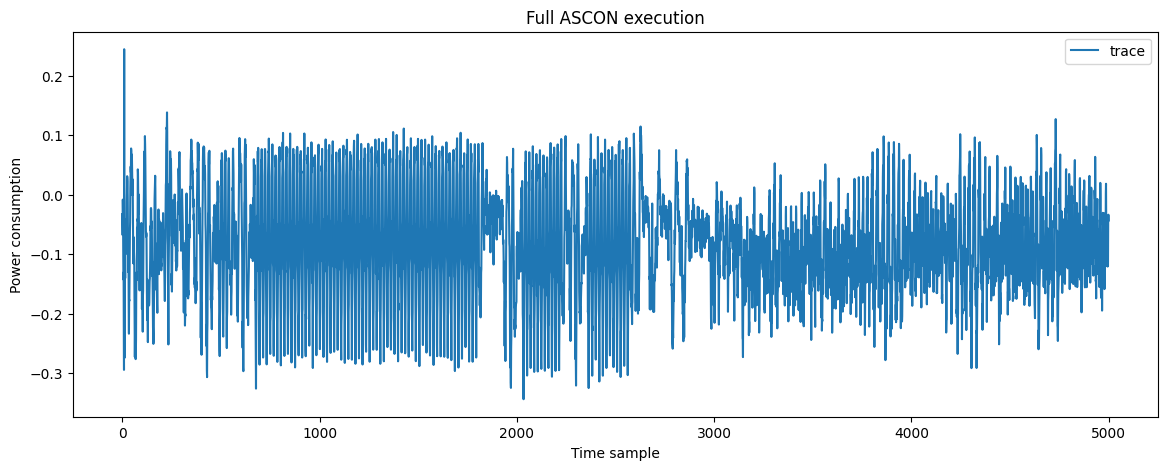

Number of leaky points are: 0


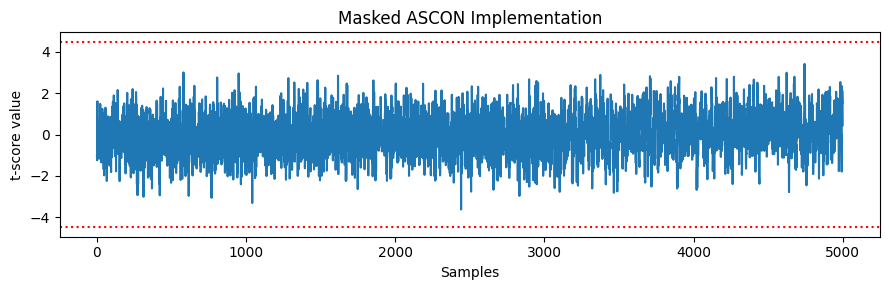

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm        

grp_array = np.array(grp_array)
grp_bools = grp_array == 1
print(grp_bools)
grp0 = trace_map[~grp_bools]
grp1 = trace_map[grp_bools]
print(grp0)
print(grp1)
print("{0} fixed, {1} random".format(len(grp0),len(grp1)))

#trace = np.load("/media/silvia/SSD1T/cw305_ibex-masked-csv/traces.npy")[0]                                                                                               
plt.figure(figsize=(14,5))
plt.plot(trace_map[0], label='trace')
plt.title('Full ASCON execution')
plt.xlabel('Time sample')
plt.ylabel('Power consumption')
plt.legend()
plt.show()

from scipy import stats

t_scores, p_values = stats.ttest_ind(grp0, grp1, axis=0, equal_var=False)
t_scores_absolute = np.absolute(t_scores)
THRESHOLD = 4.5
fails_tvla = t_scores[t_scores_absolute > THRESHOLD] 
print(f"Number of leaky points are: {len(fails_tvla)}")

#Plot the TVLA Graph
plt.figure(figsize=(9, 3))
# Write your code here
# Plot the t_score values for all the time samples
plt.plot(t_scores)

plt.xlabel("Samples")
plt.ylabel("t-score value")
plt.axhline(y=4.5, color='r', linestyle=':')
plt.axhline(y=-4.5, color='r', linestyle=':')
plt.title('Masked ASCON Implementation')
# plt.savefig("CsvunMaskedAes_TVLA.jpg")
plt.tight_layout()

In [ ]:
trace_fix_array = np.asarray([trace.wave for trace in traces_fix])
textin_array = np.asarray([trace.textin for trace in traces_fix])
known_keys = np.asarray([trace.key for trace in traces_fix])

fileCarrays = open("fixed_set", "wb")
np.savez(fileCarrays, trace_fix_array, textin_array, known_keys)
fileCarrays.close

trace_random_array = np.asarray([trace.wave for trace in traces_random])
textin_array = np.asarray([trace.textin for trace in traces_random])
known_keys = np.asarray([trace.key for trace in traces_random])

fileCarrays = open("random_set", "wb")
np.savez(fileCarrays, trace_random_array, textin_array, known_keys)
fileCarrays.close

fileCarrays = open("fixed_set", "rb")
measurements = np.load(fileCarrays)
traces_fix = measurements['arr_0']
fileCarrays.close

fileCarrays = open("random_set", "rb")
measurements = np.load(fileCarrays)
traces_random = measurements['arr_0']
fileCarrays.close

<function BufferedReader.close>

In [15]:
np.save("Fix_dastaset.npy",Fix_project.waves[:][:])
np.save("Rand_dastaset.npy",Random_project.waves[:][:])
Fix_project.save()
Random_project.save()
Fix_project.close()
Random_project.close()

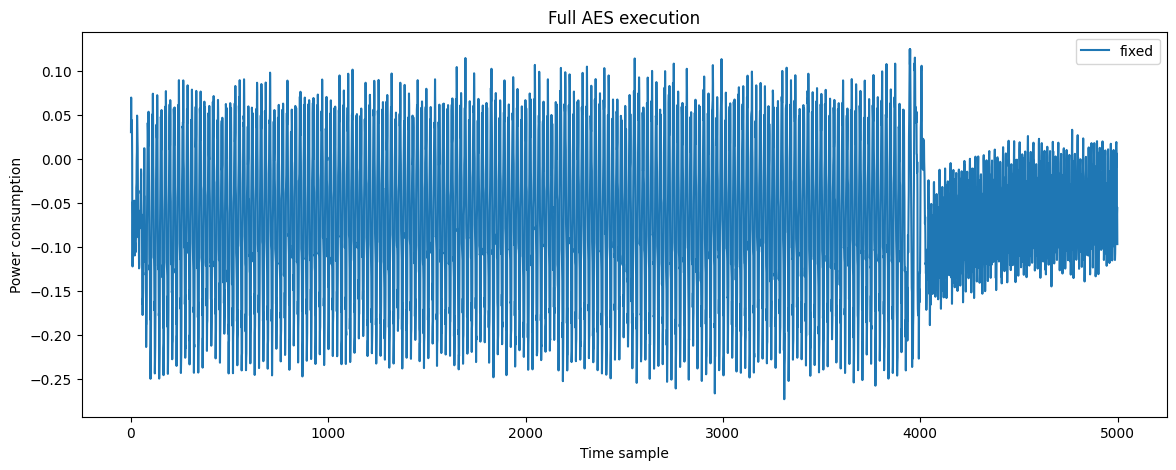

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm        

fixed_trace = np.load("Fix_dastaset.npy")[0]
random_trace = np.load("Rand_dastaset.npy")[0]                                                                                                        
plt.figure(figsize=(14,5))
plt.plot(fixed_trace, label='fixed')
#plt.plot(random_trace, label='random')
plt.title('Full AES execution')
plt.xlabel('Time sample')
plt.ylabel('Power consumption')
plt.legend()
plt.show()

### Apply the TVLA test and plot the t-scores

Number of leaky points are: 0


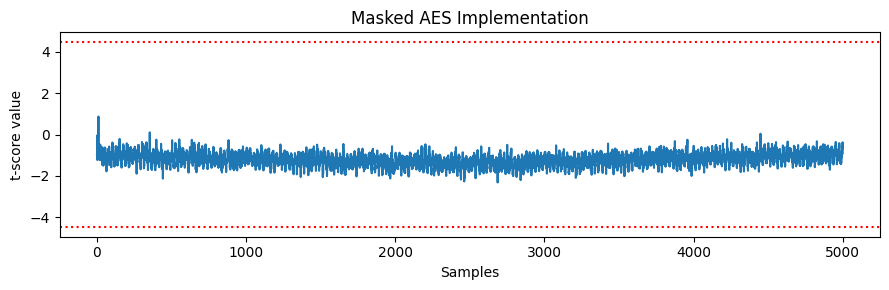

In [19]:
from scipy import stats
import matplotlib.pyplot as plt

# Write your code here.
# Use ttest_ind() to calculate the t-score for all time instances horizontally.

t_scores, p_values = stats.ttest_ind(traces_fix, traces_random, axis=0, equal_var=False)
t_scores_absolute = np.absolute(t_scores)
THRESHOLD = 4.5
fails_tvla = t_scores[t_scores_absolute > THRESHOLD] 
print(f"Number of leaky points are: {len(fails_tvla)}")

#Plot the TVLA Graph
plt.figure(figsize=(9, 3))
# Write your code here
# Plot the t_score values for all the time samples
plt.plot(t_scores)

plt.xlabel("Samples")
plt.ylabel("t-score value")
plt.axhline(y=4.5, color='r', linestyle=':')
plt.axhline(y=-4.5, color='r', linestyle=':')
plt.title('Masked AES Implementation')
plt.savefig("MaskedAes_TVLA.jpg")
plt.tight_layout()

In [20]:
for x in fails_tvla:
    print(x)

In [22]:
import numpy as np
fixed = np.load("Fix_dastaset.npy")[:, 9975:10025].astype(np.int16)
random = np.load("Rand_dastaset.npy")[:, 9975:10025].astype(np.int16)

new_fixed = np.zeros((fixed.shape[0], 1225), dtype=np.int16)
new_random = np.zeros((random.shape[0], 1225), dtype=np.int16)

for k, trace in enumerate(fixed):
    n=0
    for i in range(len(trace)):
        for j in range(i):
            new_fixed[k][n] = int(trace[i]*trace[j])
            n+=1
          
for k, trace in enumerate(random):
    n=0  
    for i in range(len(trace)):
        for j in range(i):
            new_random[k][n] = trace[i]*trace[j]
            n+=1


Number of leaky points are: 0


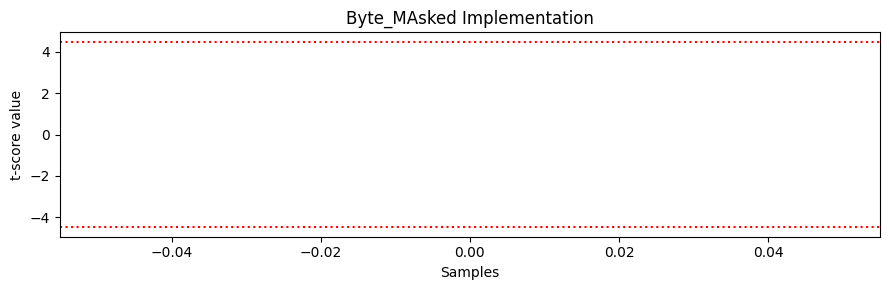

In [23]:
# Calculating second order t-values
THRESHOLD = 4.5
second_tval, p_value = stats.ttest_ind(new_fixed, new_random, equal_var=False)
second_tval_absolute = np.absolute(second_tval)
second_fails_tvla = second_tval[second_tval_absolute > THRESHOLD] 
print(f"Number of leaky points are: {len(second_fails_tvla)}")

from scipy import stats
import matplotlib.pyplot as plt

t_scores, p_values = stats.ttest_ind(np.asarray(new_fixed), np.asarray(new_random), axis=0, equal_var=False)

plt.figure(figsize=(9, 3))
plt.plot(t_scores)

plt.xlabel("Samples")
plt.ylabel("t-score value")
plt.axhline(y=4.5, color='r', linestyle=':')
plt.axhline(y=-4.5, color='r', linestyle=':')
plt.title('Byte_MAsked Implementation')
plt.savefig("Byte_MAsked_TVLA.jpg")
plt.tight_layout()

Number of leaky points are: 0


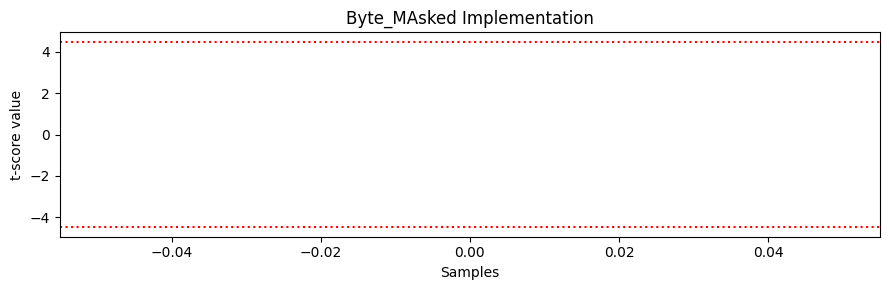

In [24]:
# Calculating second order t-values
THRESHOLD = 4.5
second_tval, p_value = stats.ttest_ind(new_fixed, new_random, equal_var=False)
second_tval_absolute = np.absolute(second_tval)
second_fails_tvla = second_tval[second_tval_absolute > THRESHOLD] 
print(f"Number of leaky points are: {len(second_fails_tvla)}")

from scipy import stats
import matplotlib.pyplot as plt

t_scores, p_values = stats.ttest_ind(np.asarray(new_fixed), np.asarray(new_random), axis=0, equal_var=False)

plt.figure(figsize=(9, 3))
plt.plot(t_scores)

plt.xlabel("Samples")
plt.ylabel("t-score value")
plt.axhline(y=4.5, color='r', linestyle=':')
plt.axhline(y=-4.5, color='r', linestyle=':')
plt.title('Byte_MAsked Implementation')
plt.savefig("Byte_MAsked_TVLA.jpg")
plt.tight_layout()